In [1]:
import numpy as np
import forward.common as common
import forward.homogeneous_semi_inf as hsi
import matplotlib.pyplot as plt

In [15]:
tau = np.logspace(-7, 0, 100)
lambda0 = 785
mua = 0.01
musp = 10
rho = 2
n = 1.4
db = 1e-9

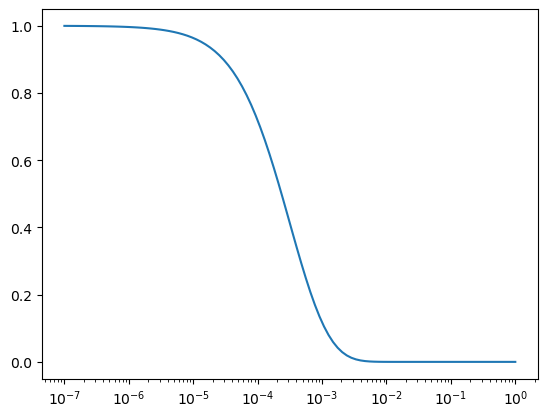

In [20]:
msd = common.msd_brownian(tau, db)
g1_norm = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)
plt.semilogx(tau, g1_norm)